<a href="https://colab.research.google.com/github/BigFoots625/Documents/blob/master/PrediksiKebutuhanParkir_RegresiLinear_TUBESAI3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# **LOAD DATASET**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("File:", filename)
print("Shape:", df.shape)
df.head()

Saving parkingStream.csv to parkingStream.csv
File: parkingStream.csv
Shape: (18368, 11)


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,Timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,2016-10-04 07:59:00
1,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,2016-10-04 07:59:00
2,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,2016-10-04 07:59:00
3,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,2016-10-04 07:59:00
4,17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,2016-10-04 07:59:00


# **PEMAHAMAN DATA**

In [ ]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  Timestamp               18368 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 1.5+ MB


,0
ID,0
SystemCodeNumber,0
Capacity,0
Latitude,0
Longitude,0
Occupancy,0
VehicleType,0
TrafficConditionNearby,0
QueueLength,0
IsSpecialDay,0


In [ ]:
print("Max Occupancy :", df["Occupancy"].max())
print("Max Capacity  :", df["Capacity"].max())
print("Occupancy > Capacity:",
      (df["Occupancy"] > df["Capacity"]).sum())


# Berapa persen yang tidak logis?
invalid_rate = ((df["Occupancy"] > df["Capacity"]).mean() * 100)
print(f"Occupancy > Capacity rate: {invalid_rate:.2f}%")


Max Occupancy : 3499
Max Capacity  : 3883
Occupancy > Capacity: 241
Occupancy > Capacity rate: 1.31%


In [ ]:
# =========================
# RINGKASAN DATA SEBELUM CLEANING
# =========================
summary_before = {
    "Jumlah Baris": len(df),
    "Jumlah Kolom": df.shape[1],
    "Duplikat": df.duplicated().sum(),
    "Occupancy > Capacity": (df["Occupancy"] > df["Capacity"]).sum(),
    "Missing Timestamp": df["Timestamp"].isna().sum()
}

pd.DataFrame(summary_before, index=["Sebelum Cleaning"])


,Jumlah Baris,Jumlah Kolom,Duplikat,Occupancy > Capacity,Missing Timestamp
Sebelum Cleaning,18368,11,0,241,0


# **PRA PROCESSING DATA**

In [ ]:
# =========================
# PRA-PEMROSESAN DATA
# =========================

# 0) Copy aman
df = df.copy()

# 1) Hapus duplikat (kalau ada)
df = df.drop_duplicates()

# 2) Rapihin tipe data & nilai dasar
df["Capacity"] = pd.to_numeric(df["Capacity"], errors="coerce")
df["Occupancy"] = pd.to_numeric(df["Occupancy"], errors="coerce")
df["QueueLength"] = pd.to_numeric(df["QueueLength"], errors="coerce")

# Buang baris yang nilainya rusak (NaN) atau negatif (tidak logis)
df = df.dropna(subset=["Capacity", "Occupancy", "QueueLength"])
df = df[(df["Capacity"] >= 0) & (df["Occupancy"] >= 0) & (df["QueueLength"] >= 0)]

# 3) Constraint fisik: Occupancy tidak boleh melebihi Capacity
df["Occupancy"] = np.minimum(df["Occupancy"], df["Capacity"])

# 4) Timestamp -> datetime, drop yang gagal parse
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"]).copy()

# 5) Feature engineering waktu
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["month"] = df["Timestamp"].dt.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["is_rush_hour"] = df["hour"].isin([7,8,9,16,17,18,19]).astype(int)

# 6) Pastikan kolom kategori bertipe string (lebih aman untuk OHE)
cat_fix = ["SystemCodeNumber", "VehicleType", "TrafficConditionNearby"]
for c in cat_fix:
    df[c] = df[c].astype(str)

# IsSpecialDay sebaiknya kategori (0/1) bukan numerik kontinu
df["IsSpecialDay"] = df["IsSpecialDay"].astype(str)

# 7) (Opsional tapi bagus) Gabungkan kategori yang terlalu jarang -> "Other"
# Ini mencegah OneHotEncoder bikin kolom terlalu banyak/noisy
def group_rare(series, min_count=200):
    vc = series.value_counts()
    keep = vc[vc >= min_count].index
    return series.where(series.isin(keep), other="Other")

df["SystemCodeNumber"] = group_rare(df["SystemCodeNumber"], min_count=200)
df["VehicleType"] = group_rare(df["VehicleType"], min_count=200)
df["TrafficConditionNearby"] = group_rare(df["TrafficConditionNearby"], min_count=200)

print("Shape setelah preprocessing:", df.shape)


Shape setelah preprocessing: (18368, 18)


In [ ]:
# =========================
# RINGKASAN DATA SETELAH CLEANING
# =========================
summary_after = {
    "Jumlah Baris": len(df),
    "Jumlah Kolom": df.shape[1],
    "Duplikat": df.duplicated().sum(),
    "Occupancy > Capacity": (df["Occupancy"] > df["Capacity"]).sum(),
    "Missing Timestamp": df["Timestamp"].isna().sum()
}

pd.DataFrame(summary_after, index=["Setelah Cleaning"])


,Jumlah Baris,Jumlah Kolom,Duplikat,Occupancy > Capacity,Missing Timestamp
Setelah Cleaning,18368,18,0,0,0


In [ ]:
comparison_df = pd.DataFrame.from_dict(
    {
        "Sebelum Cleaning": summary_before,
        "Setelah Cleaning": summary_after
    },
    orient="index"
)

comparison_df


,Jumlah Baris,Jumlah Kolom,Duplikat,Occupancy > Capacity,Missing Timestamp
Sebelum Cleaning,18368,11,0,241,0
Setelah Cleaning,18368,18,0,0,0


# **TIMESTAMP**

In [ ]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"]).copy()

df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["month"] = df["Timestamp"].dt.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# Siklikal seperti hour_sin/cos di Seoul Bike (bagus untuk pola jam)
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

# Rush hour versi parkir kampus (silakan adjust)
df["is_rush_hour"] = df["hour"].isin([7,8,9,16,17,18,19]).astype(int)


In [ ]:
df.tail()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,Timestamp,hour,dayofweek,month,is_weekend,hour_sin,hour_cos,is_rush_hour
18363,3935,BHMEURBRD01,470,26.149020,91.739503,373,car,low,2,0,2016-12-19 16:30:00,16,0,12,0,-0.866025,-0.5,1
18364,2623,BHMBCCTHL01,387,26.144495,91.736205,387,car,low,2,0,2016-12-19 16:30:00,16,0,12,0,-0.866025,-0.5,1
18365,1311,BHMBCCMKT01,577,26.144536,91.736172,193,cycle,low,2,0,2016-12-19 16:30:00,16,0,12,0,-0.866025,-0.5,1
18366,17055,Others-CCCPS98,3103,26.147500,91.727978,1671,car,low,3,0,2016-12-19 16:30:00,16,0,12,0,-0.866025,-0.5,1
18367,18367,Shopping,1920,26.150504,91.733531,1180,car,low,2,0,2016-12-19 16:30:00,16,0,12,0,-0.866025,-0.5,1


# **TARGET DAN FITUR DATA**

In [ ]:
num_cols = [
    "Capacity", "Latitude", "Longitude", "QueueLength",
    "hour", "dayofweek", "month", "is_weekend",
    "hour_sin", "hour_cos", "is_rush_hour"
]

cat_cols = [
    "SystemCodeNumber",
    "VehicleType",
    "TrafficConditionNearby",
    "IsSpecialDay"
]

X = df[num_cols + cat_cols]
y = df["Occupancy"].astype(float)


In [ ]:
# Feature matrix (X) dan target (y)
X = df[num_cols + cat_cols]
y = df["Occupancy"].astype(float)


# **KORELASI MATRIKS**

In [ ]:
corr_cols = num_cols + ["Occupancy"]
corr_matrix = df[corr_cols].corr()


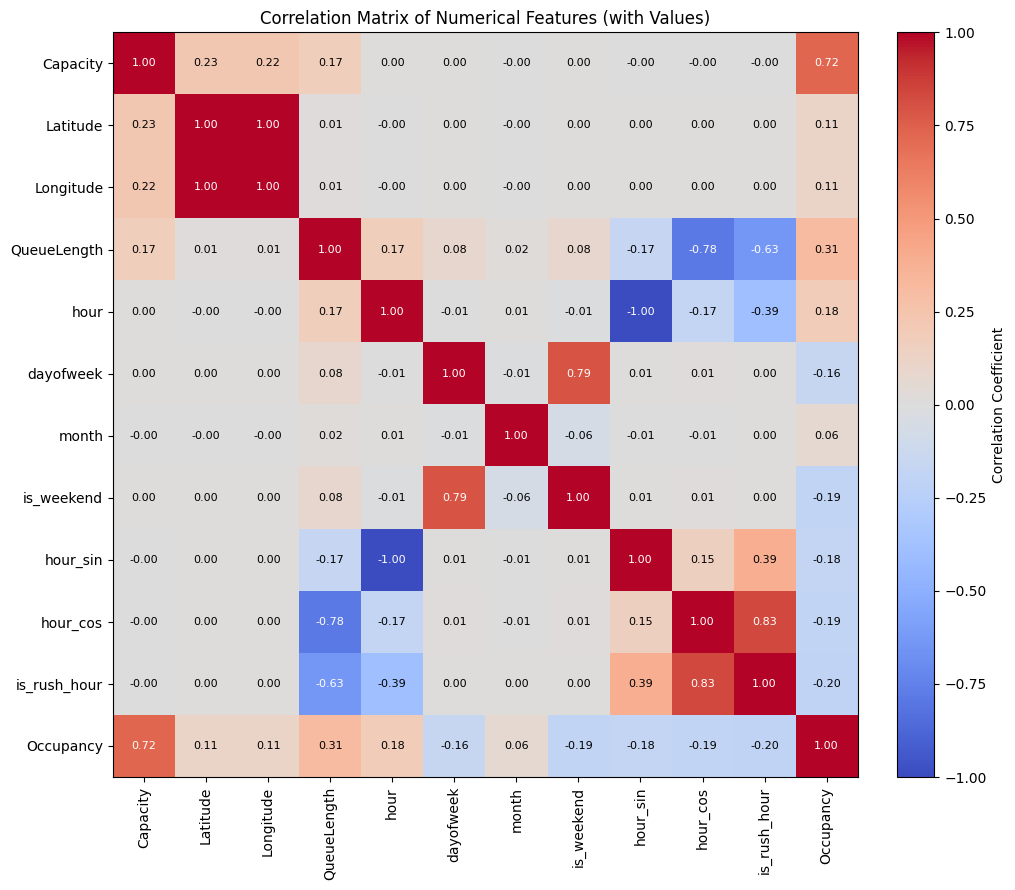

In [ ]:
plt.figure(figsize=(11,9))
im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)

plt.colorbar(im, fraction=0.046, pad=0.04, label="Correlation Coefficient")

plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)

# Tambahkan angka di tiap sel
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        value = corr_matrix.iloc[i, j]
        plt.text(
            j, i, f"{value:.2f}",
            ha="center", va="center",
            color="black" if abs(value) < 0.6 else "white",
            fontsize=8
        )

plt.title("Correlation Matrix of Numerical Features (with Values)")
plt.tight_layout()
plt.show()


# **KORELASI TERHADAP TARGET**

In [ ]:
corr_target = corr_matrix["Occupancy"].sort_values(ascending=False)

corr_target.to_frame("Correlation_with_Occupancy")


,Correlation_with_Occupancy
Occupancy,1.000000
Capacity,0.721825
QueueLength,0.311106
hour,0.181124
Latitude,0.114062
Longitude,0.112656
month,0.055462
dayofweek,-0.160275
hour_sin,-0.178038
hour_cos,-0.189649


In [ ]:
pd.concat([
    corr_target.head(5),
    corr_target.tail(5)
]).to_frame("Correlation_with_Occupancy")


,Correlation_with_Occupancy
Occupancy,1.000000
Capacity,0.721825
QueueLength,0.311106
hour,0.181124
Latitude,0.114062
dayofweek,-0.160275
hour_sin,-0.178038
hour_cos,-0.189649
is_weekend,-0.191843
is_rush_hour,-0.199621


# **SPLIT DATA**
80% data → training

20% data → testing

random_state=42 → hasil konsisten (reproducible)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
print("Total data       :", len(df))
print("Data training X  :", X_train.shape)
print("Data testing X   :", X_test.shape)
print("Target training y:", y_train.shape)
print("Target testing y :", y_test.shape)


Total data       : 18368
Data training X  : (14694, 15)
Data testing X   : (3674, 15)
Target training y: (14694,)
Target testing y : (3674,)


# **DATA PIPELINE**

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])


In [ ]:
from sklearn import set_config
set_config(display="diagram")


In [ ]:
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Capacity', 'Latitude',
                                                   'Longitude', 'QueueLength',
                                                   'hour', 'dayofweek', 'month',
                                                   'is_weekend', 'hour_sin',
                                                   'hour_cos',
                                                   'is_rush_hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SystemCodeNumber',
                                                   'VehicleType',
                                                   'TrafficConditionNearby',
                                                   'IsSpecialDay'])])),
                ('model', LinearRegression())])

# **DATA TESTING**

In [ ]:
# =========================
# 7.1 Pelatihan dan Prediksi
# =========================

# 1) Training (target di-sqrt)
y_train_sqrt = np.sqrt(y_train)
pipe.fit(X_train, y_train_sqrt)

# 2) Prediksi pada data testing (masih skala sqrt)
y_pred_sqrt = pipe.predict(X_test)

# 3) Kembalikan ke skala asli
y_pred = np.square(y_pred_sqrt)

# 4) Clip sesuai kapasitas per lokasi (occupancy per lokasi)
cap_test = X_test["Capacity"].values
y_pred_clip = np.clip(y_pred, 0, cap_test)

# 5) Tabel perbandingan 10 sampel pertama
compare_df = pd.DataFrame({
    "Actual_Occupancy": y_test.iloc[:10].values.astype(int),
    "Predicted_Occupancy": np.rint(y_pred_clip[:10]).astype(int),
    "Capacity": X_test["Capacity"].iloc[:10].values.astype(int),
})

compare_df["Abs_Error"] = (compare_df["Actual_Occupancy"] - compare_df["Predicted_Occupancy"]).abs()

compare_df


,Actual_Occupancy,Predicted_Occupancy,Capacity,Abs_Error
0,670,690,1200,20
1,318,369,485,51
2,120,176,1200,56
3,308,390,485,82
4,480,505,1200,25
5,583,664,2803,81
6,382,248,2803,134
7,889,961,2009,72
8,930,999,1920,69
9,808,945,3103,137


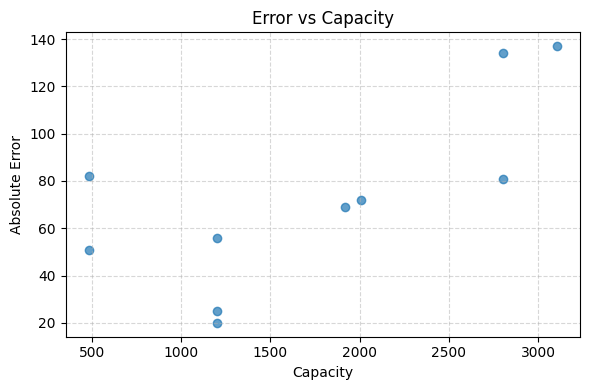

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(compare_df["Capacity"], compare_df["Abs_Error"], alpha=0.7)

plt.xlabel("Capacity")
plt.ylabel("Absolute Error")
plt.title("Error vs Capacity")

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


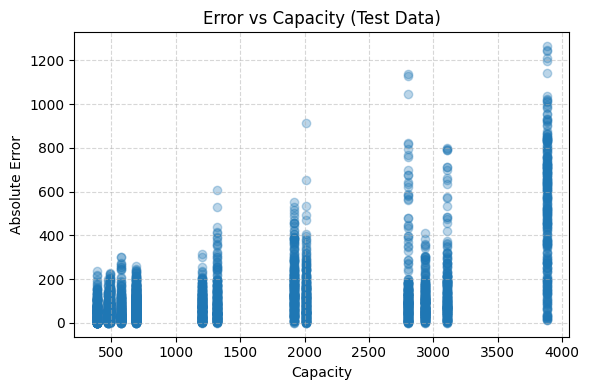

In [ ]:
abs_error = np.abs(y_test - y_pred_clip)

plt.figure(figsize=(6,4))
plt.scatter(X_test["Capacity"], abs_error, alpha=0.3)

plt.xlabel("Capacity")
plt.ylabel("Absolute Error")
plt.title("Error vs Capacity (Test Data)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# **MODEL EVALUATION**

In [ ]:
r2 = r2_score(y_test, y_pred_clip)
mae = mean_absolute_error(y_test, y_pred_clip)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_clip))

pd.DataFrame({
    "metric": ["R²", "MAE", "RMSE"],
    "value": [r2, mae, rmse]
})


,metric,value
0,R²,0.885861
1,MAE,132.062227
2,RMSE,213.396280


# **VISUALISASI HASIL**

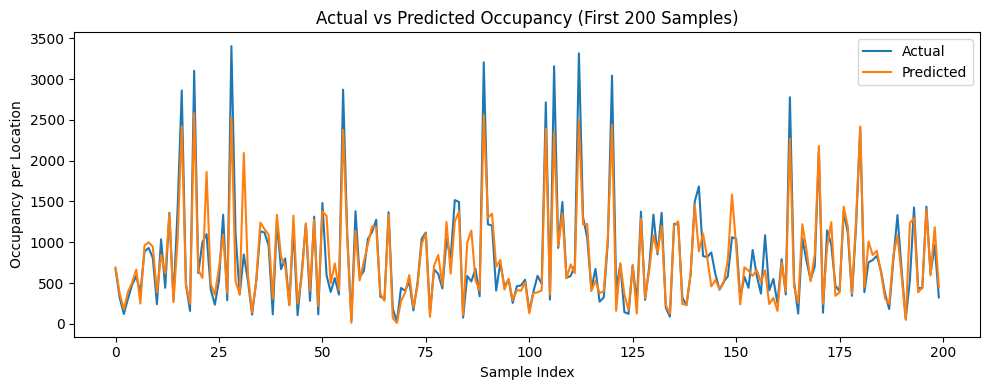

In [ ]:
n = 200
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:n], label="Actual")
plt.plot(y_pred_clip[:n], label="Predicted")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Occupancy per Location")
plt.title("Actual vs Predicted Occupancy (First 200 Samples)")
plt.tight_layout()
plt.show()

# **RESIDUAL FORMAT**

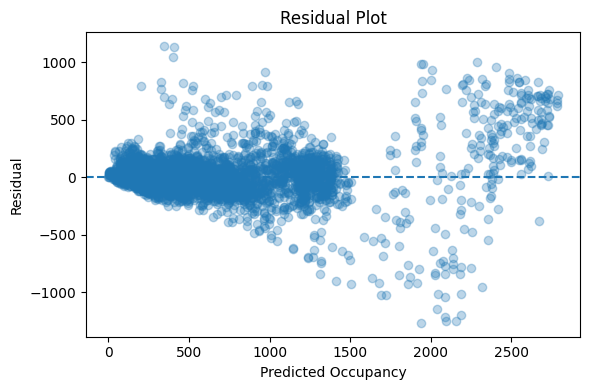

In [ ]:
residuals = y_test - y_pred_clip

plt.figure(figsize=(6,4))
plt.scatter(y_pred_clip, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Occupancy")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


# **SCATTER**

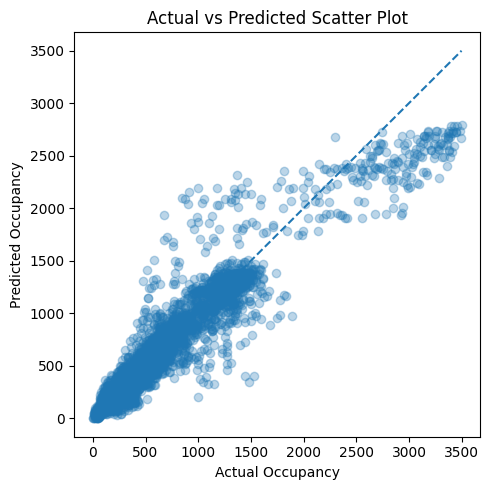

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_clip, alpha=0.3)
maxv = max(y_test.max(), y_pred_clip.max())
plt.plot([0, maxv], [0, maxv], '--')
plt.xlabel("Actual Occupancy")
plt.ylabel("Predicted Occupancy")
plt.title("Actual vs Predicted Scatter Plot")
plt.tight_layout()
plt.show()


# **ANALISI KOEFISIEN**

In [ ]:
preprocessor = pipe.named_steps["preprocess"]

cat_transformer = preprocessor.named_transformers_["cat"]
ohe = cat_transformer if not hasattr(cat_transformer, "named_steps") \
      else list(cat_transformer.named_steps.values())[-1]

feature_names_num = np.array(num_cols)
feature_names_cat = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

coefs = pipe.named_steps["model"].coef_
coefs = coefs.ravel()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})
coef_df["Abs"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs", ascending=False)

coef_df.head(15)


,Feature,Coefficient,Abs
19,SystemCodeNumber_Others-CCCPS119a,-9.348458,9.348458
20,SystemCodeNumber_Others-CCCPS135a,7.070035,7.070035
0,Capacity,6.743752,6.743752
18,SystemCodeNumber_Others-CCCPS105a,5.550927,5.550927
11,SystemCodeNumber_BHMBCCMKT01,-5.498812,5.498812
24,SystemCodeNumber_Shopping,4.826560,4.826560
4,hour,3.696707,3.696707
3,QueueLength,3.150317,3.150317
30,TrafficConditionNearby_high,-2.883730,2.883730
23,SystemCodeNumber_Others-CCCPS98,-2.767404,2.767404
